# Predictive maintanance

This is a notebook where we try to do predictive maintanance over some data. The idea is to take as input some metrics, and output if the system requires maintanance. For this matter I decided to use the xgboost algorithm, which is based on random trees.


In [2]:
# load ml and analysis libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.preprocessing import OrdinalEncoder
import re
from xgboost import plot_tree
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Confusion Matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

In [5]:
# Load the csv file into a pandas dataframe
df = pd.read_csv("./predictive_maintenance.csv")

# Use regex to remove special characters from the columns name
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns.values]

# Use the rename method to change just one type of character
df.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)

# The ordinal encoder is to encode the labels of categorical data
ord_enc = OrdinalEncoder()

df.columns

Index(['UDI', 'Product_ID', 'Type', 'Air_temperature__K_',
       'Process_temperature__K_', 'Rotational_speed__rpm_', 'Torque__Nm_',
       'Tool_wear__min_', 'Target', 'Failure_Type'],
      dtype='object')

# Sepparating the data in input and expected output

The dataset is separated between X and Y, where X is the inputs and Y is the expected output. 

Also, cathegorical data is converted to numerical, by encoding it with the ord_enc.

In [6]:
# Loc is the recommended method to slice data when using an array with the column names 
# iloc is used when we use numbers to slice data, both are shown below
x_data = df.iloc[:,:-2]
x_data.loc[:,['Product_ID', 'Type']] = ord_enc.fit_transform(x_data.loc[:,['Product_ID', 'Type']]).astype(int)

y_data = df.loc[:,df.columns[-2:]]
y_data.loc[:,['Failure_Type']] = ord_enc.fit_transform(y_data.loc[:,['Failure_Type']]).astype(int)

x_data['Product_ID'].value_counts(), x_data['Type'].value_counts(), x_data.columns

(7003    1
 5015    1
 5009    1
 5010    1
 5011    1
        ..
 7989    1
 7990    1
 3002    1
 3003    1
 9999    1
 Name: Product_ID, Length: 10000, dtype: int64, 1    6000
 2    2997
 0    1003
 Name: Type, dtype: int64, Index(['UDI', 'Product_ID', 'Type', 'Air_temperature__K_',
        'Process_temperature__K_', 'Rotational_speed__rpm_', 'Torque__Nm_',
        'Tool_wear__min_'],
       dtype='object'))

In [7]:
# Splitting the data in train/test data, 80/20 relation, using sklearn train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.20)

# Creating the model XGBoost model

With this model we want to predict two things, Target and Failure_Type, so there could be two approaches: 

- Create one model for each
- Use the MultiOutputClassifier

In [8]:
# creating the XGBoost model and fitting it
target_model = XGBClassifier()
target_model.fit(X_train, y_train['Target'])

failure_model = XGBClassifier()
failure_model.fit(X_train, y_train['Failure_Type'])

XGBClassifier(objective='multi:softprob')

In [9]:
# Creating a model that supports multioutput
multioutput_model = MultiOutputClassifier(XGBClassifier())
multioutput_model.fit(X_train, y_train)

print("Multi-Output Training Accuracy: ", multioutput_model.score(X_train, y_train)*100, "%")

Multi-Output Training Accuracy:  98.95 %


In [10]:
y_pred_target = target_model.predict(X_test)
predictions = [round(value) for value in y_pred_target]


# evaluate predictions
accuracy = accuracy_score(y_test['Target'], predictions)
print("Accuracy for target: %.2f%%" % (accuracy * 100.0))


# make predictions for test data
y_pred_failure = failure_model.predict(X_test)
predictions = [round(value) for value in y_pred_failure]


# evaluate predictions
accuracy = accuracy_score(y_test['Failure_Type'], predictions)
print("Accuracy for Failure type: %.2f%%" % (accuracy * 100.0))

# make predictions for test data
y_pred_total = multioutput_model.predict(X_test)


# Performance Metrics
print("Test Accuracy (Target)       : ",accuracy_score(y_test.iloc[:,0], y_pred_total[:,0])*100,"%")
print("Test Precision (Target)      : ",precision_score(y_test.iloc[:,0], y_pred_total[:,0])*100,"%")
print("Test Recall (Target)         : ",recall_score(y_test.iloc[:,0], y_pred_total[:,0])*100,"%")
print("Test Accuracy (Failure Type) : ",accuracy_score(y_test.iloc[:,1], y_pred_total[:,1])*100,"%")
print("Test F1-score (Target)       : ", f1_score(y_test.iloc[:,0], y_pred_total[:,0])*100,"%")

Accuracy for target: 98.05%
Accuracy for Failure type: 97.90%
Test Accuracy (Target)       :  98.05 %
Test Precision (Target)      :  84.0909090909091 %
Test Recall (Target)         :  53.62318840579711 %
Test Accuracy (Failure Type) :  97.89999999999999 %
Test F1-score (Target)       :  65.48672566371683 %


In [11]:
# Visualizations

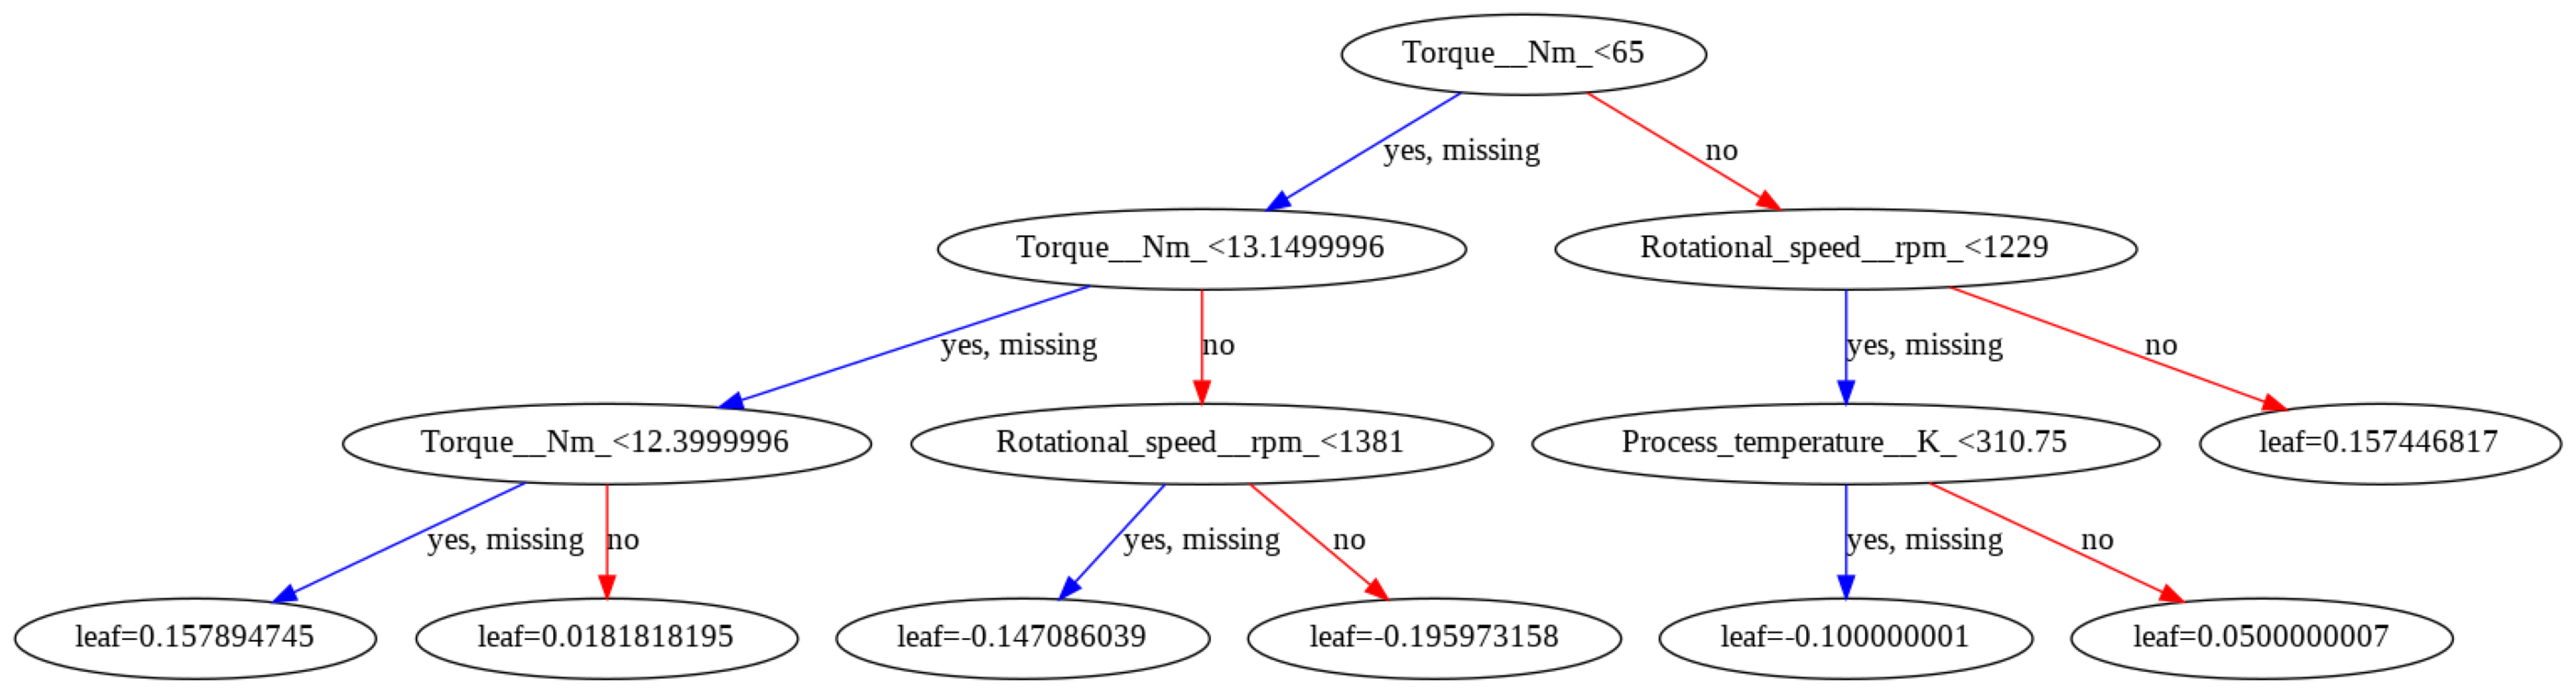

In [12]:
from matplotlib.pylab import rcParams

# Printing the decision tree created with XGBoost

rcParams['figure.figsize'] = 50,30
plot_tree(target_model)
plt.show()

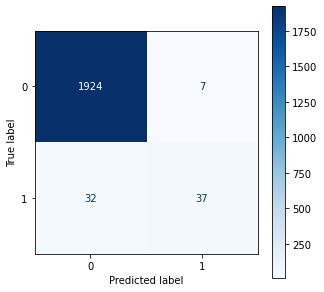

In [13]:
# A confusion matrix for the results

cm             = confusion_matrix(y_test.iloc[:,0],
                                  y_pred_total[:,0])

disp           = ConfusionMatrixDisplay(confusion_matrix=cm,)

fig, ax        = plt.subplots(figsize = (5,5))

disp.plot(cmap = plt.cm.Blues,
          ax   = ax)